In [114]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
import xgboost as xgb 

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
# rcParams["font.size"] = 14
# rcParams["text.usetex"] = True
# rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

In [115]:


####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function
def makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='test'):

    fig = py.figure(figsize=(17, 5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax_list  = [ax1,ax2,ax3]
    x0 = 0.9*xlim[0]+0.1*xlim[1]
    y0 = 0.15*ylim[0]+0.85*ylim[1]    

    delta = y_trn-p_y_trn
    ax = ax_list[0]
    ax.plot(y_trn, delta, 'g.', alpha=0.3)
    ax.set_title('Training Set', fontsize=22)
    ax.set_ylabel(ylabel, fontsize=20)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=18, color='k')
    
    delta = y_cvl-p_y_cvl
    ax = ax_list[1]
    ax.plot(y_cvl, delta, 'r.', alpha=0.7)
    ax.set_title('Cross Validation Set', fontsize=22)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=18, color='k')

    delta = y_tst-p_y_tst
    ax = ax_list[2]
    ax.plot(y_tst, delta, 'b.', alpha=0.7)
    ax.set_title('Test Set', fontsize=22)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=18, color='k')

    for ax in ax_list:
        
        ax.set_xlabel(xlabel, fontsize=20)
        ax.plot(xlim, [0,0], 'k:')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 


    plt.subplots_adjust(wspace=0.05)
#######################################

In [116]:
## loading data
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

In [20]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split,RandomizedSearchCV


table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=200, N_test=200)
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'i_w2'
X_train, y_train = ML_data(table_trn, features, output)

#set up XGBoost 
max_depth = 10
n_trees = 10
learning_rate = 0.01
min_samples_leaf = 10
max_features=3
# xgbr = xgb.XGBRegressor(n_estimators = n_trees, max_depth = max_depth, eta= learning_rate) 

regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_trees, \
        max_features=max_features, min_samples_leaf=min_samples_leaf, \
            bootstrap=True)

#choose a set of parameters over which to do the hyperparameter search
xgbr_params_dist = {'max_depth': sp_randint(3, 20),
                    'n_estimators': sp_randint(10, 10000), #10000
                    'min_samples_leaf':sp_randint(5, 50),
                    'max_features':sp_randint(1, 4)
                   }

#set up the random search
rand_xgbr = RandomizedSearchCV(regr, param_distributions = xgbr_params_dist, n_iter = 20, cv=5, 
                               n_jobs = -1, verbose = 10 )
#run the random search
rand_xgbr.fit(X_train, y_train)

print("Best xgbr parameters set:")
print(rand_xgbr.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  5.4min remaining:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished


Best xgbr parameters set:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=14,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=8146, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)


Feature Importances:  [0.1640513  0.03052799 0.06605077 0.73936993]
g_r 	-->  16.4%
r_i 	-->  3.1%
i_z 	-->  6.6%
pc0 	-->  73.9%


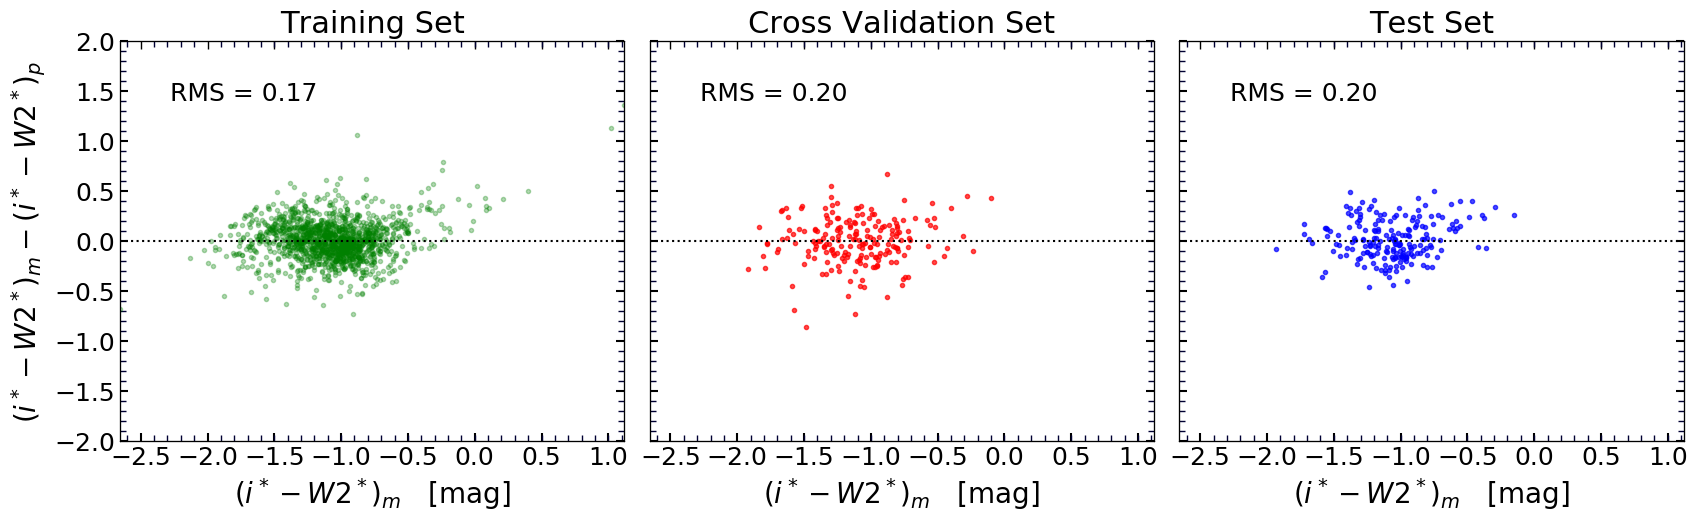

In [117]:
## Sample management
## table_tst: Test table
## table_cvl: Cross Validation table
## table_trn: Training Table
## N_test: Number of test data points
## N_cross: Number of cross validation data points
## Seed_test: Random seed number to choose the test sample (i.e. fixed=0)
## Seed_cross: Random seed number to choose the cross validation sample 
##                     (can be changed to see the algorithm performance)
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=200, N_test=200)
import pylab as py

################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'i_w2'
max_depth=9
n_estimators=8146
max_features=3 #len(features)
min_samples_leaf=14
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.1f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.1f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'i^*-W2^*'
text_unit = 'mag'
x0 = np.min(table_trn[output])
x1 = np.max(table_trn[output])
xlabel = r'$('+text+')'+'_{m}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{m}'+'-'+'('+text+')'+'_{p}$'
xlim = [x0,x1]
ylim = [-2,2]

d = np.abs(p_y_trn-y_trn)
tt = 0.6
indx, = np.where((d<tt) & (y_trn<0) )
X = y_trn[indx]
Xp = p_y_trn[indx]
Y = X-Xp
m, b = np.polyfit(X,Y, 1)

# m=0
# b=0

p_y_trn = (p_y_trn+b)/(1-m)
p_y_cvl = (p_y_cvl+b)/(1-m)
p_y_tst = (p_y_tst+b)/(1-m)

makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')




In [52]:
band2 = 'w2'
inFile = 'ESN_HI_catal.csv'
scaler, pca = transform(inFile, band1 = 'r', band2 = 'w2')

u = scaler.mean_
s = scaler.scale_
v = scaler.var_
## z = (x-u)/s
##u: mean  s:scale  var=s**2

A = pca.explained_variance_ratio_              # The importance of different PCAs components

pca_inv_data = pca.inverse_transform(np.eye(3)) # coefficients to make PCs from features
p0 = pca_inv_data[0,0]
p1 = pca_inv_data[0,1]
p2 = pca_inv_data[0,2]

print u
print s
print p0, p1, p2

inFile = '../calibrators/ESN_HI_catal_all.csv'
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None, encoding=None)
table = extinctionCorrect(table)
table = Kcorrection(table)

# indx = np.asarray(range(650,670))
# table = trim(table, indx)

table['mu50'] = table[band2]+2.5*np.log10(2.*np.pi*(table['R50_'+band2]*60)**2)-2.5*np.log10(table['Wba'])
dWba2 = ((0.1/6./table['R50_'+band2])**2)*(1+table['Wba']**2)
c2 = (2.5/np.log(10))**2
table['Emu50']=np.sqrt(c2*(0.1/6./table['R50_'+band2])**2+c2*dWba2/table['Wba']**2+0.05**2)
table['EC82'] = (5*np.sqrt(2.)/np.log(10))*(0.1/6./table['R50_'+band2])

table['R50_w2p'] = halflight(table["R50_g"], table["R50_r"], table["R50_i"], table["R50_z"])
table['Wbap'] = ba(table["Sba"])

## u0, g0, r0, i0, z0 are already K-/extinction- corrected
table['u0'] = table['u']
table['g0'] = table['g']
table['r0'] = table['r']
table['i0'] = table['i']
table['z0'] = table['z']
table['w10']= table['w1']
table['w20']= table['w2']
table["scaler"] = scaler
table["Cpca"]   = pca

[ 2.46891601  1.62619868 23.34763463]
[0.17994179 1.14575053 1.38289888]
0.5245280452302963 0.6007370022417068 -0.603312012067165


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in divide
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in divide


In [33]:
indx, = np.where(table['pgc']==4992)
j = indx[0]

u = table['u'][j]
g = table['g'][j]
r = table['r'][j]
i = table['i'][j]
z = table['z'][j]
w1 = table['w1'][j]
w2 = table['w2'][j]
print u,g,r,i,z,w1,w2

table_cvl = table

14.480031396493125 13.155102220929757 12.50544342235041 12.173377938803696 12.015932017854862 12.321960450192444 12.914000450192445


4992 65 12.914000450192445
38 12.851073823081752 [-5.15795529e-09]
Delta W: 0.06


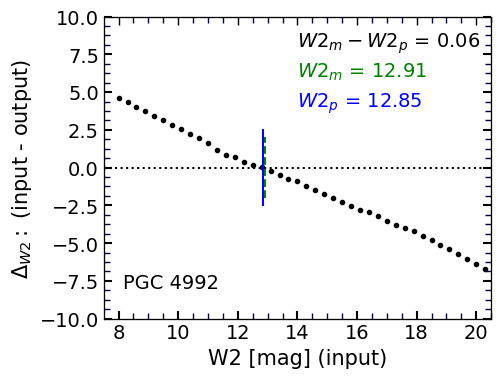

In [34]:
# j = 50
PGC  = table_cvl['pgc'][j]
W2   = table_cvl['w2'][j]
INC  = table_cvl["inc"][j]
M21  = table_cvl["m21"][j]
M0   = table_cvl["logWimx"][j]
WBA  = table_cvl["Wba"][j]
WBAp = table_cvl["Wbap"][j]
R50  = table_cvl["R50_w2"][j]
R50p = table_cvl["R50_w2p"][j]

print PGC, INC, W2
def f(w2):
    return predictor(w2, table_cvl, regr, features, output, index=j, useFullPredictions=True, m=m, b=b)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,20.5,0.3):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')
    


ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,20.5], [0,0], 'k:')    
ax.set_xlim([7.5,20.5])
ax.set_ylim([-10,10])
xlim = ax.get_xlim()
ylim = ax.get_ylim()

set_axes([ax], xlim, ylim)


x0 = 0.95*xlim[0]+0.05*xlim[1]
y0 = 0.9*ylim[0]+0.1*ylim[1]
ax.text(x0,y0, 'PGC '+'%d'%PGC, fontsize=14, color='k')


ax.set_xlabel('W2 [mag] (input)', fontsize=15)
ax.set_ylabel(r'$\Delta_{W2}:$'+' (input - output)', fontsize=15)
###############################################

out = solver(f, 7, 21, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    
    
    x0 = 0.50*xlim[0]+0.50*xlim[1]
    y0 = 0.1*ylim[0]+0.90*ylim[1]
    ax.text(x0,y0, r'$W2_m-W2_p$'+' = '+'%.2f'%(W2-w2p), fontsize=14, color='k')
    y0 = 0.2*ylim[0]+0.80*ylim[1]
    ax.text(x0,y0, r'$W2_m$'+' = '+'%.2f'%(W2), fontsize=14, color='green')
    y0 = 0.3*ylim[0]+0.70*ylim[1]
    ax.text(x0,y0, r'$W2_p$'+' = '+'%.2f'%w2p, fontsize=14, color='blue')    
    
    
    
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)

    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'b-') 


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


0.20$\pm$0.00
-1.09$\pm$0.00


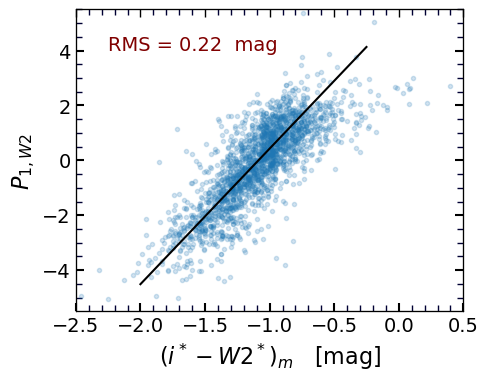

In [128]:
inFile = '../calibrators/corrected_mags_linewidth_all.csv'
table = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)

c_i_w2 = table['i_s'] - table['w2_s']
c_pc0  = table['P0_w2']
c_pc0e  = table['P0_w2_e']

Wqlt = table['Wqlt']
Sqlt = table['Sqlt']

R_source = table['R_source']

indx0, = np.where((Sqlt>2) & (Wqlt>2) & (c_i_w2<-0.7) & (c_i_w2>-1.5))
indx, = np.where((Sqlt>3) & (Wqlt>3) & (R_source==2) )


fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)


ax.plot(c_i_w2[indx], c_pc0[indx], '.', alpha=0.2)

set_axes([ax], (-2.5,0.5), (-5.5,5.5))

fit, cov = np.polyfit(c_i_w2[indx0], c_pc0[indx0], 1, w=1./c_pc0e[indx0], cov=True)
xx = np.linspace(-2,-0.25,100)
ax.plot(xx, fit[0]*xx+fit[1], 'k-')

rms = np.sqrt(np.mean((c_i_w2[indx]-(c_pc0[indx]-fit[1])/fit[0])**2))
ax.text(-2.25,4, 'RMS = '+'%.2f'%rms+'  mag', fontsize=14, color='maroon')



text     = 'i^*-W2^*'
text_unit = 'mag'
ax.set_xlabel(r'$('+text+')'+'_{m}$'+'   ['+text_unit+']', fontsize=16)
ax.set_ylabel(r'$P_{1,W2}$', fontsize=16)

m, b = fit
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]    
m0 = 1./m
b0 = -b/m
dm0 = np.abs(me/m**2)
db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))

print '%.2f'%m0+'$\pm$'+'%.2f'%dm0
print '%.2f'%b0+'$\pm$'+'%.2f'%db0



In [108]:
A = R_source[indx]
len(A[A<2])

176